In [366]:
import torch
import torchaudio
from IPython import display as display_
from torch import nn
import pandas as pd
%pylab inline
import torch.optim as optim
import torch.nn.functional as F
import time
import random

Populating the interactive namespace from numpy and matplotlib


## Построение модели для распознавания речи

В задании было сказано использовать Quartznet, так что её версию мы и будем использовать, но не 5x5, а с 3 повторениями среднего блока (слои и гиперпараметры будем брать из статьи)

К сожалению, оказалось, что кроме наличия видеокарты, необходимы драйвера, программы. (Я почти день обучал, но не прошёл даже эпоху, понял что видеокарта всё таки не используется, хотя на меньших данных время обучения менялось. После чего вскоре я перестал пытаться установить доп. нужный софт) Так что данный были выбраны из LJSpeech

Обучал я только на первых файлах, так как использовать 13000 файлов было бы в десятки раз дольше. Это сильно сказалось на качестве сети, но хотя бы на train данных она обучилась (скорее переобучилась, так как не смогла найти общих закономерностей, но значительного ухудшения качество на тестовых данных замечено не было)

In [2]:
URL = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
train_dataset = torchaudio.datasets.LJSPEECH("./data", url = URL, download = True)

In [3]:
from torch import distributions

Для CTC loss есть встроенная функция в torch, но для wer - нет

In [77]:
def wer(predict, target):
    predict = predict.split()
    if (len(predict[-1]) > 10):
        predict[-1] = predict[-1][:10]
    target = target.split()
    d = torch.zeros((len(target)+1, len(predict)+1))
    for i in range(len(target)+1):
        d[i][0] = i
    for j in range(len(predict)+1):
        d[0][j] = j
    for i in range(1, len(target)+1):
        for j in range(1, len(predict)+1):
            if target[i-1] == predict[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = min(d[i-1][j-1], d[i][j-1], d[i-1][j]) + 1
    return float(d[len(target)][len(predict)]) / len(target) * 100

Нужно реализовать аугментацию данных (хотя бы 4, но если увеличить количество данных в 4 раза, то будут снова проблемы), так что мы выберем 4 типа агументации: не менять, добавить шум из нормального распределения, изменить громкость, добавить звук адского огня на фон

In [4]:
noise, sr = torchaudio.load('data/hellfire.wav')
noise.squeeze_()
noise = torch.cat([noise[10000:-10000]] * 9, dim=0)
noise_voler = torchaudio.transforms.Vol(0.1)
noize_level = torch.Tensor([1])
noize_energy = torch.norm(noise)

В коде будут присутствовать и другие функции, которые будут преобразовывать данные, но они были написано мною до того, как я узнал о возможности/необходимости написать новый класс TextTransform. Потом я узнал об этом, как его писать и был написан следующий код

text_to_int и int_to_text - функции, которые переводят последовательность номеров класса в предложение и наоборот (символы в словаре - eps, space и буквы английского алфавита

data_processing пытается открыть архиф с файлами, взять оттуда аудиофайл и соответствующее ему предложение. Сигнал он преобразует в мелспектрограмму с 64 каналами, а потом использует masking. Предложения с помощью описанной ранее функции он переводит в последовательности номеров классов. Так как для ctc_loss нужны будут input_lenths и label_lengths (или target_lengths), то функция возвращает ещё и их

(некоторые строчки в коде закомментированны, так как они в основном пытались использовать cuda)

In [175]:
class TextTransform:
    def __init__(self):
        self.index = {}
        self.index[0] = ""
        self.index[1] = " "
        for i in range(2, 28):
            self.index[i] = chr(i + 95)

    def text_to_int(self, text):
        answer = []
        for symb in text:
            if symb == ' ':
                answer.append(1)
            else:
                answer.append(ord(symb) - 95)
        return answer

    def int_to_text(self, target):
        string = []
        for i in target:
            string.append(self.index[int(i)])
        return ''.join(string)

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

text_transform = TextTransform()

def data_processing(data):
    spectrograms = []
    targets = []
    input_lengths = []
    targets_lengths = []
    noiser = distributions.Normal(0, 0.01)
    voler = torchaudio.transforms.Vol(2)
    for (waveform, a, d, utterance) in data:
        spect = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spect_1 = train_audio_transforms(waveform + noiser.sample(waveform.size())).squeeze(0).transpose(0, 1)
        spect_2 = train_audio_transforms(voler(waveform)).squeeze(0).transpose(0, 1)        
        audio_energy = torch.norm(waveform)
        alpha = (audio_energy / noize_energy) * torch.pow(10, -noize_level / 5)
        this_noise = noise[:waveform.shape[0]]
        spect_3 = train_audio_transforms(waveform + alpha * this_noise).squeeze(0).transpose(0, 1)
        specs = [spect, spect_1, spect_2, spect_3]
        spectrograms.append(specs[random.randint(0, 3)])
        target = torch.Tensor(text_transform.text_to_int(utterance.replace("!", "").replace("?", "").replace("'", "").replace(":", "").replace(";", "").replace("(", "").replace(")", "").replace(",", "").replace(".", "").replace("\"", "").replace("-", " ").replace(";", " ").lower()))
        targets.append(target)
        input_lengths.append(spect.shape[0]//2)
        targets_lengths.append(len(target))
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).transpose(1, 2)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)
    return spectrograms, targets, input_lengths, targets_lengths

In [6]:
class smQuartzNet(nn.Module):
    def __init__(self):
        super(smQuartzNet, self).__init__()
        
        self.start = nn.Sequential(
            nn.Conv1d(64, 256, kernel_size=[33], stride=[2], padding=(16,), groups=64, bias=False),
            nn.modules.batchnorm.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        self.repeated_1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=[33], stride=[1], padding=(16,), groups=256, bias=False),
            nn.Conv1d(256, 256, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
        )
        self.repeated_parallel_1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=(1,), stride=[1], bias=False),
            nn.modules.batchnorm.BatchNorm1d(256, eps=0.001, momentum=0.1),
        )
        self.union_1 = nn.Sequential(
            nn.ReLU(),
        )
        
        self.repeated_3 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=[51], stride=[1], padding=(25,), groups=256, bias=False),
            nn.Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[51], stride=[1], padding=(25,), groups=512, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.repeated_parallel_3 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.union_3 = nn.Sequential(
            nn.ReLU(),
        )
        
        self.repeated_5 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=[75], stride=[1], padding=(37,), groups=256, bias=False),
            nn.Conv1d(512, 512, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.repeated_parallel_5 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=(1,), stride=[1], bias=False),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
        )
        self.union_5 = nn.Sequential(
            nn.ReLU(),
        )
        
        self.near_near_end = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=87, padding=(86,)),
            nn.modules.batchnorm.BatchNorm1d(512, eps=0.001, momentum=0.1),
            nn.ReLU(),
        )
        self.near_end = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1),
            nn.modules.batchnorm.BatchNorm1d(1024, eps=0.001, momentum=0.1),
            nn.ReLU(),
        )
        self.end = nn.Sequential(
            nn.Conv1d(1024, 28, kernel_size=(1,), stride=(1,))
        )
        
        
    def forward(self, x):
        x = self.start(x)
        x = self.union_1(self.repeated_parallel_1(x) + self.repeated_1(x))
        x = self.union_3(self.repeated_parallel_3(x) + self.repeated_3(x))
        x = self.union_5(self.repeated_parallel_5(x) + self.repeated_5(x))
        x = self.near_near_end(x)
        x = self.near_end(x)
        return self.end(x)

In [346]:
'''
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
'''

'\nuse_cuda = torch.cuda.is_available()\ntorch.manual_seed(7)\ndevice = torch.device("cuda" if use_cuda else "cpu")\n'

In [195]:
#model = smQuartzNet().to(device)
model = smQuartzNet()

In [196]:
optimizer = optim.AdamW(model.parameters(), 2e-4)

In [197]:
#criterion = nn.CTCLoss(blank=0).to(device)
criterion = nn.CTCLoss(blank=0)

In [208]:
batch = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                            batch_size=batch,
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x),
                            **kwargs)

Для сохранения процесса обучения, мы будем запоминать значения loss, wer и выходы сети на одном из train и test предложений (правда, оказалось, что я случайно использовал не новое предложение, а высказывание из конца тренировочных данных, так что потом я просто использовал сети, которые я сохранял примерно на 5, 8, 20 и последней эпохах, так как осталось всего полнедели до дедлайна и у меня всё равно не было бы времени дообучить новую модель, которая хорошо распознаёт речь и по ней видно, как она обучается)

In [231]:
first_sents = []
test_sents = []

In [212]:
wers_history = []
loss_history = []

In [315]:
a = time.time()
for i in range(12):
    j = 0
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        #spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1).transpose(0, 2) # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        loss_history += [loss.item()]
        out_sent = output.transpose(0, 1).transpose(2, 1)
        for i in range(batch):
            wers_history += [wer(build_sentence(out_sent[i]), text_transform.int_to_text(labels[i]))]
        j += 1
        print(j, time.time() - a)
        if (j > 9):
            wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0001.wav')
            spectr = [train_audio_transforms(wav).squeeze(0).transpose(0, 1)]
            spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
            out = model(spectrs)
            out = F.log_softmax(out, dim=2)
            out = out.transpose(0, 1).transpose(0, 2)
            out = out.transpose(0, 1).transpose(2, 1)
            first_sents.append(build_sentence(out[0]))
            wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0040.wav')
            spectr = [train_audio_transforms(wav).squeeze(0).transpose(0, 1)]
            spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
            out = model(spectrs)
            out = F.log_softmax(out, dim=2)
            out = out.transpose(0, 1).transpose(0, 2)
            out = out.transpose(0, 1).transpose(2, 1)
            test_sents.append(build_sentence(out[0]))
            print("sents are saved")
            break

print(time.time() - a)

1 205.34308505058289
2 432.37361454963684
3 643.7639880180359
4 857.4813258647919
5 1039.6148433685303
6 1215.9618842601776
7 1424.261867761612
8 1614.100774526596
9 1807.5926134586334
10 2011.3477809429169
sents are saved
1 2239.2580964565277
2 2433.2118813991547
3 2623.673503637314
4 2855.053279399872
5 3017.849593639374
6 3203.1581909656525
7 3435.145352602005
8 3602.543159008026
9 3810.5453600883484
10 4022.6886682510376
sents are saved
1 4250.603695869446
2 4445.440446853638
3 4643.837242603302
4 4874.61067533493
5 5059.862133264542
6 5248.846335887909
7 5471.141050577164
8 5643.640472650528
9 5887.913678884506
10 6119.892172336578
sents are saved
1 6349.064980983734
2 6535.101065635681
3 6742.7773270606995
4 6965.149380207062
5 7135.9402384758
6 7328.062928199768
7 7546.236406326294
8 7743.280715227127
9 7966.382971525192
10 8202.638167142868
sents are saved
1 8434.917808055878
2 8636.348617076874
3 8850.8817923069
4 9062.605769634247
5 9246.803705453873
6 9433.225053071976
7 965

In [225]:
metadata = pd.read_csv('data/LJSpeech-1.1/metadata.csv', sep = '|', header=None, index_col = 0)

In [347]:
#saving outputs of the model
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0041.wav')
spectr = [train_audio_transforms(wav).squeeze(0).transpose(0, 1)]
spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
out = model(spectrs)
out = F.log_softmax(out, dim=2)
out = out.transpose(0, 1).transpose(0, 2)
out = out.transpose(0, 1).transpose(2, 1)
'''
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0040.wav')
spectr = [train_audio_transforms(wav).squeeze(0).transpose(0, 1)]
spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
out = model(spectrs)
out = F.log_softmax(out, dim=2)
out = out.transpose(0, 1).transpose(0, 2)
out = out.transpose(0, 1).transpose(2, 1)
test_sents.append(build_sentence(out[0]))
'''
print(build_sentence(out[0]))

buthfinsnsnbokopnldled d twn wtiw wmmtmtatelaeaeu u ugf br uthwcwcgscgcucfnw ryryrywymrgrxqxzxjzjzjzqjzqzqjzqzjzv


Посмотрим на то, как постепенно менялось распознавание первого и сорокогого предложения из аудиофайлов

Настоящее предложение звучит так:

In [350]:
def viz(wav):
    figsize(20, 5)
    plot(wav)
    plt.show()
    display_.display(display_.Audio(wav, rate=22050, normalize=False))

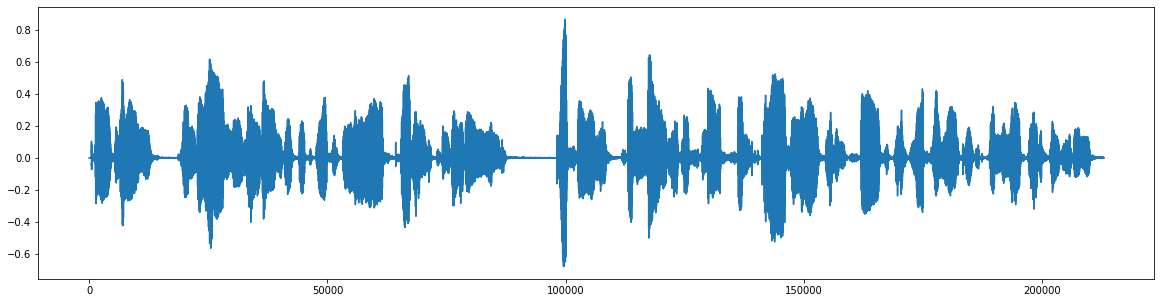

In [362]:
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0001.wav')
wav.squeeze_()
viz(wav)

In [363]:
metadata[1][0]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

In [348]:
first_sents

['hinoplwatyed bptped blf rfrltltl sateyxzqjh',
 'uhinbvoplated s sccctptped fkrdrd msatyxzqjqjqju',
 'hihnvbvolawcpcped sfcptped batfrmlgrsaftyeyeyxzqzqzjqjqjqjq',
 'tuivnvolmwher scped fkkam ufmblapcsngfgthexyxzjzjq',
 'uhinvwoklywer bcpedfkmbm ufblatau ngnupsnfgthexynzqzqzqjqjqjq',
 'bnh in wokvly whwer skcred fmufblaugua psd gthexygnzjzjqjqjqjqjqjqjqjqjqz',
 'an iuhnbnbnbnvnvokvlyswhwerarpapapspscncred fkm tflarauspsbtgtexyzjqjqjqzjqb',
 'buhihnbnhbhvhbhuonvlyn whceara sncrnedfgkmtfuablauaf pseti igthexzvnkzjqjqjqjqz',
 'bt inbnbwovlyn whwearp pmsasngcgckckredfbkmkmkmn nbfmmlelau gf psedgtgthexyitgnzjqjqjqjqz',
 'bubingn uovlyn whcwear a sskceredfkm ot tuotfblhauafpcsedngthexkzjqjqjqjqjqjqz',
 'binvgvbvovlysns wh wearerer prsgngncpedffbkkm ou f frmllar aufrprpsneng thexybtgnvzjzqzqjqj',
 'buhihgngbeokvlyngwhwear a iesncrnedfms t ntfbmalauafs presed in thexybtgngzjqjqjqjzjzjqzqjqjqjqj',
 'buingbhvovlye whweare a rirsncrerned ifrrrbomot fofrml the as auasprsntdn thexybtignzjqjqjqjqjq

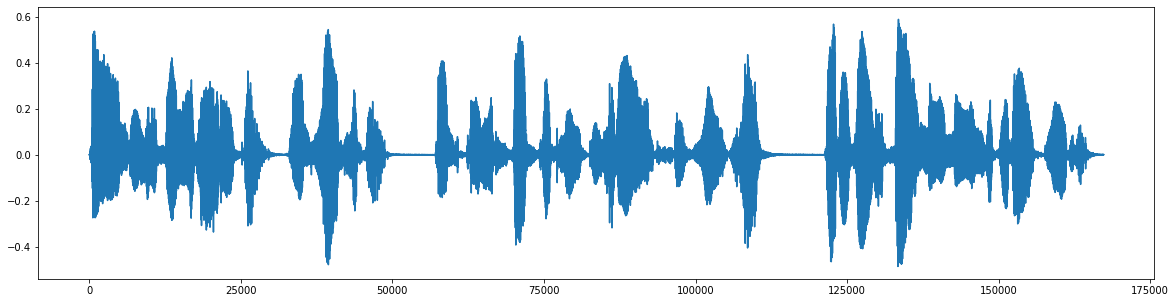

In [364]:
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0040.wav')
wav.squeeze_()
viz(wav)

In [365]:
metadata[1][39]

'and is very simple and legible, and unaffectedly designed for use; but it is by no means without beauty.'

In [327]:
test_sents

['hinboptlmeyd btleled s fckctmedryxzqjh',
 'uhinvoplmed bted safafctearyxzqjqjqjqju',
 'hisvopclerd bsafted obn aryxzjqjqjqjqjqjqjqu',
 'tuisvomplend okobkanfcter sbnthmaurtrtrtyxzqjq',
 'hisvfmplend bgknfctcs srgcsbonwhaultyxzqjqjqjqjqjqz',
 'tuhisgvomplend lgbknfctys r csbonmwhulauauarurgtryxyxyxzjzjzqjqjqjqz',
 'an isvery mplend lgbkkknunfcteldesgn fr sbomwhubaugtgtyxyxzqjqjqz',
 'tu his vwvfosomple nd lgbn nfcte eses ryryxicisbobokowthumbaurntyxyxyxyxyxyxzqjzqjzjqzqjqjqjqjqj',
 'tnhw isvwfomplend lgbkanuafctlsg frus u i sbnomnwhu baurgtxyxyxzqjqjqk',
 'nd insgvfysmple nd lgobkanunfctely esger r s s sbomswhut baugtgtxtxyxzqzjqjqjqz',
 'budwisvfosimple nd lgbkanunfctel esgnrfru ut t sbom nwhoutbaurmtxyxzqzqjqjqjqjqjqj',
 'huhwhisvosimple and lgbkan unfctedlysgn frus ut it sbom whut bauro txyxyxzqzqjqzqj',
 'nwis vrysmple and lgbkanufctdy esgnd for use butisbomnwhu baurtrytyxyxyxyxzqjqjqjzjzjqjqjqz',
 'and is vwrysmple and lgbkkan unafctel ese for usr ut t sbomnwhou beaurtyryxyxzqzjq

In [318]:
wers = []
ind = 0
for i in range(len(loss_history)):
    a = 0
    a += wers_history[ind]
    a += wers_history[ind + 1]
    a += wers_history[ind + 2]
    a += wers_history[ind + 3]
    ind += 4
    wers += [a / 4]

In [341]:
real_loss = []
real_wer = []
for i in range(int(len(loss_history) / 10)):
    a = 0
    b = 0
    for j in range(10):
        b += wers[i * 10 + j]
        a += loss_history[i * 10 + j]
    real_loss += [a / 10]
    real_wer += [b / 10]

In [83]:
import matplotlib.pyplot as plt

Мы увидели, как меняются предсказания на предложениях, а теперь посмотрим на графики обучения

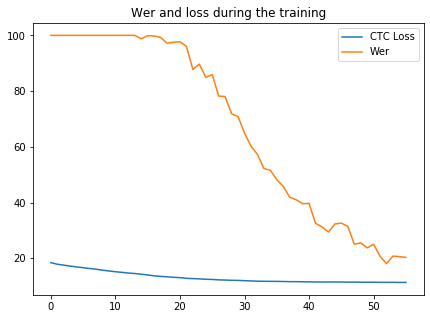

In [377]:
figsize(7, 5)
plt.plot(range(len(real_loss)), real_loss)
plt.plot(range(len(real_wer)), real_wer)
plt.title("Wer and loss during the training")
plt.legend(['CTC Loss', 'Wer'])
plt.show()

Так как такой wer сложно получить, хоть я и не использовал валидационную выборку, но посмотрим на предсказания моделей на тестовом предложении, заметим, что он не распознаётся

А раз на train ошибка небольшая, то, видимо, сеть переобучилась ровно на этих файлах

In [382]:
model_1 = torch.load('data/model.pth')
model_1.eval()
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0041.wav')
spectr = [train_audio_transforms(wav).squeeze(0).transpose(0, 1)]
spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
out = model(spectrs)
out = F.log_softmax(out, dim=2)
out = out.transpose(0, 1).transpose(0, 2)
out = out.transpose(0, 1).transpose(2, 1)
print(build_sentence(out[0]))
for i in range(1, 5):
    model_1 = torch.load('data/model' + str(i) + '.pth')
    model_1.eval()
    out = model_1(spectrs)
    out = F.log_softmax(out, dim=2)
    out = out.transpose(0, 1).transpose(0, 2)
    out = out.transpose(0, 1).transpose(2, 1)
    print(build_sentence(out[0]))

buhivnsbnybookowoxopcpcpnleldlf nd anwt wtwmtmthmanaealtpeanetedbg f  pcwseoeuefucuconrsrsrurtgtryrpyxrygymyrgxzxqkxzjzqzqzqzqzqjqzqjzk
andwhinsasmnyefrwvf boplabad evn mdmsamtgtctpeypeyrne drdf scutuecgsxyrxydrxzqzqzjzqzjzqjqjk
bndwhfiae fcamnbfwofobopkplafa ad vevn m m mtvntpepeprne gdrdf scuttrntrgsryrypyxyxygydmdrdxjxzxzqzqzqzjqjzjqjqj
bud whiasfsvnvbkbfowvcbopplafbad evn m mtptvntpeptperedgrdf smcutwa ntccfecgnrsryrxrgydgryrxkzkxqzqzqjzjzjzqjqzqk
bud thfivnvsnsnvn oy eowcbcuoplgbad eanam mtntpeltaperegerdf cwccecgnrsryrypyxyxymgrtgkxkxkzqjzjqjzjqjqjqjqjk


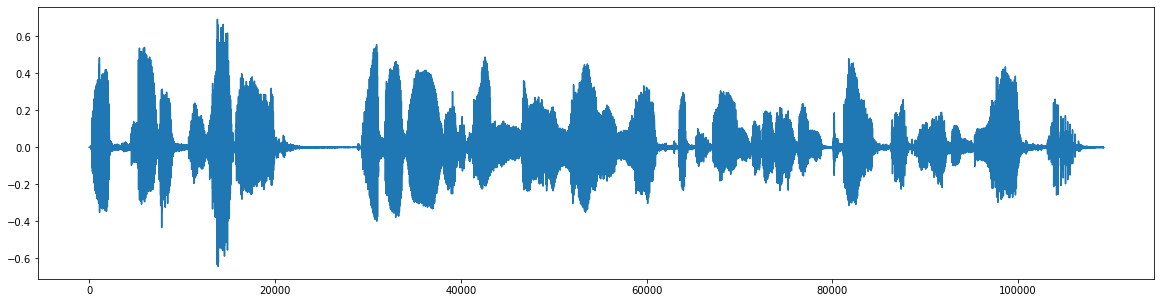

In [383]:
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0041.wav')
wav.squeeze_()
viz(wav)

In [384]:
metadata[1][40]

'It must be said that it is in no way like the transition type of Subiaco,'

На семинаре было сказано, что beam_search надстраивается сверху на сеть, так что сейчас напишем свою версию и используем: вдруг он улучшит предсказания

In [488]:
def main_symb(probs):
    i = 0
    maxim = probs[i]
    for j in range(1, len(probs)):
        if (probs[j] > maxim):
            maxim = probs[j]
            i = j
    if i == 0:
        return '`', maxim, i
    elif i == 1:
        return ' ', maxim, i
    else:
        return chr(95 + i), float(maxim), i

In [614]:
def beam_search(predicts, beams = 3, sentences = [[1, ""]]):
    best = []
    probs = predicts[:, 0]
    probs += 1 - min(probs)
    probs = probs / probs.sum()
    t_answer = []
    for i in range(beams):
        s, p, ind = main_symb(probs)
        probs[ind] = 0
        best.append([s, p])
    if sentences[0][1] == "":
        for i in range(beams):
            t_answer.append([sentences[0][0] * best[i][1], sentences[0][1] + best[i][0]])
    else:
        for i in range(beams):
            for j in range(len(sentences)):
                if (sentences[j][1][-1] == '`'):
                    string = sentences[j][1][:-1] + best[i][0]
                elif (sentences[j][1][-1] == best[i][0]):
                    string = sentences[j][1]
                else:
                    string = sentences[j][1] + best[i][0]
                prob = sentences[j][0] * best[i][1]
                t_answer.append([prob, string])
    t_answer = sorted(t_answer, reverse = True)
    answer = [t_answer[0]]
    for i in range(1, len(t_answer)):
        answer = sorted(answer, reverse = True)
        added = False
        for j in range(len(answer)):
            if (answer[j][1] == t_answer[i][1]):
                answer[j][0] += t_answer[i][0]
                added = True
                break
        if (added == False and len(answer) < beams):
            answer.append(t_answer[i])
        elif (added == False and t_answer[i][0] > answer[-1][0]):
            answer[-1] = t_answer[i]
    answer = sorted(answer, reverse = True)
    if predicts.shape[1] == 1:
        return answer[0][1]
    else:
        if predicts.shape[1] % 10 == 0:
            print(sorted(answer, reverse = True))
        return beam_search(predicts[:, 1:], beams, sorted(answer, reverse = True))
    

In [615]:
out = model(spectrs)
out = F.log_softmax(out, dim=2)
out = out.transpose(0, 1).transpose(0, 2)
out = out.transpose(0, 1).transpose(2, 1)
#beam_search(out[0], 3)
#print(i)

In [619]:
beam_search(out[0, :, :100], 1)

[[0.05967419221997261, 'b']]
[[5.606667056853544e-13, 'buinti']]
[[6.974501632559708e-23, 'buinti']]
[[1.684209568893666e-33, 'buinting']]
[[tensor(0., grad_fn=<MulBackward0>), 'buinting i']]
[[tensor(0., grad_fn=<MulBackward0>), 'buinting in the ']]
[[tensor(0., grad_fn=<MulBackward0>), 'buinting in the o']]
[[tensor(0., grad_fn=<MulBackward0>), 'buinting in the o']]
[[tensor(0., grad_fn=<MulBackward0>), 'buinting in the on']]
[[tensor(0., grad_fn=<MulBackward0>), 'buinting in the onl']]


'buinting in the only'

In [612]:
wav, sr = torchaudio.load('data/LJSpeech-1.1/wavs/LJ001-0001.wav')
spectr = [train_audio_transforms(wav).squeeze(0).transpose(0, 1)]
spectrs = nn.utils.rnn.pad_sequence(spectr, batch_first=True).transpose(1, 2)
out = model(spectrs)
out = F.log_softmax(out, dim=2)
out = out.transpose(0, 1).transpose(0, 2)
out = out.transpose(0, 1).transpose(2, 1)
#print(build_sentence(out[0]))
out[0]

tensor([[-11.6762, -11.7170, -10.9117,  ..., -13.2584, -12.9938, -12.5889],
        [-10.4234, -10.8670,  -9.6401,  ..., -13.2269, -12.8361, -12.2248],
        [ -5.1955,  -7.0907,  -8.0692,  ..., -13.1056, -12.5523, -11.6914],
        ...,
        [-11.2303, -12.0768, -11.6712,  ...,  -8.5061,  -8.5531,  -8.7169],
        [ -9.2366,  -9.7577,  -9.3940,  ..., -12.0378, -11.8115, -11.4901],
        [-11.8439, -13.3652, -13.1644,  ...,  -4.6333,  -4.8333,  -5.3290]],
       grad_fn=<SelectBackward>)

In [16]:
def max_symb(probs):
    i = 0
    maxim = probs[i]
    for j in range(1, len(probs)):
        if (probs[j] > maxim):
            maxim = probs[j]
            i = j
    if i == 0:
        return '`'
    elif i == 1:
        return ' '
    else:
        return chr(95 + i)

def build_sentence(probs):
    answer = max_symb(probs[:, 0])
    for i in range(1, probs.shape[1]):
        symb = max_symb(probs[:, i])
        if (answer[-1] != symb):
            if (answer[-1] == '`'):
                answer = answer[:-1] + symb
            else:
                answer = answer + symb
    return answer

In [620]:
torch.save(model, 'data/final_model.pth')

Использовать мою модель можно так же, как я выводил предсказания для 41-го файла. Последние веса сохранены в 'final_model.pth'